In [1]:
# import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.autograd import Variable
from time import time
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train1.csv')
df2 = pd.read_csv('testAll.csv')

In [3]:
class RatingDataset(data.Dataset):
    def __init__(self, users, items, ratings):
        self.users = users 
        self.items =items
        self.rating = ratings
    
    def __len__(self):
        return len(self.rating)
    
    def __getitem__(self, idx):
        return torch.tensor(self.users[idx]),torch.tensor(self.items[idx]), torch.tensor(self.rating[idx])  

In [4]:
# load data
train = RatingDataset(df['userId']-1, df['movieId']-1, df['rating']*1.0)
test = RatingDataset(df2['userId']-1, df2['movieId']-1, df2['rating']*1.0)

bg = df['rating'].mean()

n_users = df['userId'].max()
n_items = df['movieId'].max()
(n_users, n_items)

(500, 1000)

In [5]:
train_dataloader = data.DataLoader(train, batch_size=100, shuffle=True)
test_dataloader = data.DataLoader(test, batch_size=100)

In [6]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, bg, n_factors=40):
        super().__init__()
        self.bg = torch.tensor(bg)
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        self.user_biases = nn.Embedding(n_users, 1)
        self.item_biases = nn.Embedding(n_items, 1)
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)
        self.user_biases.weight.data.fill_(0.)
        self.item_biases.weight.data.fill_(0.)
       

    def forward(self, user, item):
        pred = self.user_biases(user) + self.item_biases(item)+ self.bg
        pred += ((self.user_factors(user) * self.item_factors(item)).sum(dim=1, keepdim=True))
        return pred.squeeze()

In [7]:
model = MatrixFactorization(n_users, n_items, bg, n_factors=40)
loss_func = nn.MSELoss()
l1_loss = nn.L1Loss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=5e-2)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD([model.user_biases.weight,model.user_factors.weight], lr=0.05, weight_decay=1e-5) # learning rate

In [8]:
start = time()
epoches = 200
L =[]
mae=[]
# mse=[]

for epoch in range(epoches):
    l =0.0
    for i,(users, items, ratings) in enumerate(train_dataloader):
        users = Variable(torch.LongTensor(users))
        items = Variable(torch.LongTensor(items))
        ratings = Variable(torch.FloatTensor(ratings.float()))
        
        # Predict and calculate loss for user factor and bias
        prediction = model(users, items)
        loss = loss_func(prediction, ratings)    
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        optimizer.zero_grad()
        l += loss.item()
    L.append(l)
    
    m = 0.0
    total = 0
    for j, (users, items, ratings) in enumerate(test_dataloader):
        users = Variable(torch.LongTensor(users))
        items = Variable(torch.LongTensor(items))
        ratings = Variable(torch.FloatTensor(ratings.float()))

        prediction = model(users, items)
        m += l1_loss(prediction.round(), ratings).item()
        total += ratings.size(0)
    m/=total
    if len(mae)!=0 and m > mae[-1]: break
    mae.append(m) 
        
print(round(time()-start), epoch)


/usr/local/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


34 13


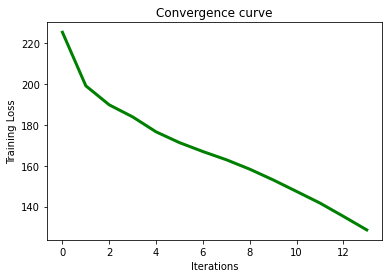

In [9]:
fig1 = plt.figure('Training Loss')
x = range(len(L))
plt.plot(x, L, color='g',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.show()

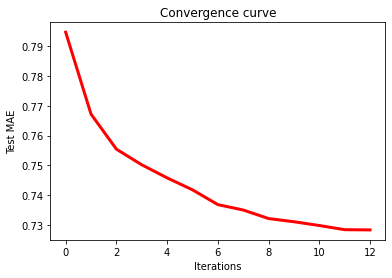

In [10]:
x = range(len(mae))
plt.plot(x, mae, color='r',linewidth=3)
plt.title('Convergence curve')
plt.xlabel('Iterations')
plt.ylabel('Test MAE')
plt.show()

In [11]:
pred = []
for j, (users, items, ratings) in enumerate(test_dataloader):
    users = Variable(torch.LongTensor(users))
    items = Variable(torch.LongTensor(items))
    ratings = Variable(torch.FloatTensor(ratings.float()))

    prediction = model(users, items)
    pred.extend(prediction.tolist())

In [12]:
target=df2['rating']
pred=torch.tensor(pred).round()
target = torch.tensor(target)

In [13]:
l1_loss(pred.float(), target)/target.size(0)

tensor(0.7285)

In [14]:
mae[-1]

0.7283286816614677

In [15]:
# torch.save(model,'mf_model.pt')